In [ ]:
!pip install wordcloud

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import re
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from collections import Counter
from wordcloud import WordCloud
import plotly.express as px

In [ ]:
nltk.download('punkt')
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


True

### 데이터셋 로드

In [ ]:
df = pd.read_csv("/content/drive/MyDrive/빅데이터/project/reddit_ai_data_cleaned.csv")

In [ ]:
df.head()

,subreddit,title,body,created_date,year,month,keyword
0,ChatGPT,Forming Relationships and dating an AI: Part Two,This is a follow up to my first post \n[https...,2024-12-22 01:43:59,2024,12,"['follow', 'first', 'post', 'okay', 'wow', 'be..."
1,ChatGPT,AI can't be random?,"In both, ChatGPT and Gemini, I asked ""Tell me ...",2024-12-22 01:24:55,2024,12,"['chatgpt', 'gemini', 'ask', 'tell', 'random',..."
2,ChatGPT,The moral dilemma of AI powered by nuclear energy,I recently learned something that I am having ...,2024-12-21 23:11:08,2024,12,"['recently', 'learn', 'something', 'trouble', ..."
3,ChatGPT,AI Incest is a thing,I did now find out about AI incest. For those ...,2024-12-21 23:04:45,2024,12,"['find', 'ai', 'incest', 'know', 'refer', 'lit..."
4,ChatGPT,How AI Helped Me Navigate a Misdiagnosis.,I know some people post fake “how AI helped me...,2024-12-21 22:50:53,2024,12,"['know', 'people', 'post', 'fake', 'ai', 'help..."


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19418 entries, 0 to 19417
Data columns (total 7 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   subreddit     19418 non-null  object
 1   title         19418 non-null  object
 2   body          19418 non-null  object
 3   created_date  19418 non-null  object
 4   year          19418 non-null  int64 
 5   month         19418 non-null  int64 
 6   keyword       19418 non-null  object
dtypes: int64(2), object(5)
memory usage: 1.0+ MB


### EDA

##### 텍스트 길이 분포

In [ ]:
# 본문 길이 계산
df['body_length'] = df['body'].str.len()

# 히스토그램
fig = px.histogram(
    df,
    x='body_length',
    nbins=20,
    color_discrete_sequence=px.colors.sequential.Blugrn,
    title="Distribution of Body Length"
)

# 테두리 설정
fig.update_traces(
    marker_line_color='black',
    marker_line_width=0.5
)

fig.update_layout(
    xaxis_title="Body Length (characters)",
    yaxis_title="Number of Posts",
    template="plotly_white",
    width=800,
    height=500
)

fig.show()

In [ ]:
# 제목 길이 계산
df['title_length'] = df['title'].str.len()

# Plotly를 사용한 히스토그램
fig = px.histogram(
    df,
    x='title_length',
    nbins=20,  # 히스토그램의 빈 개수
    color_discrete_sequence=px.colors.sequential.Burg,
    title="Distribution of Title Length"
)

# 테두리 설정
fig.update_traces(
    marker_line_color='black',
    marker_line_width=0.5
)

# 그래프 크기 및 레이아웃 설정
fig.update_layout(
    xaxis_title="Title Length (characters)",
    yaxis_title="Number of Posts",
    template="plotly_white",
    width=800,
    height=500
)

fig.show()

##### 연도별 분포

In [ ]:
df['created_date'] = pd.to_datetime(df['created_date'])

In [ ]:
# 연도 추출
df['year'] = df['created_date'].dt.year
yearly_distribution = df['year'].value_counts().sort_index()

# 데이터프레임으로 변환
yearly_df = yearly_distribution.reset_index()
yearly_df.columns = ['year', 'count']

# Plotly 막대 그래프 생성
fig = px.bar(
    yearly_df,
    x='year',
    y='count',
    title="Distribution of Posts by Year"
)

# 막대 색상과 테두리 설정
fig.update_traces(
    marker_color='skyblue',
    marker_line_color='black',
    marker_line_width=0.5
)

# 그래프 레이아웃 설정
fig.update_layout(
    xaxis_title="Year",
    yaxis_title="Number of Posts",
    template="plotly_white",
    width=800,
    height=500
)

fig.show()

##### 단어 빈도수

In [ ]:
# 문자열을 리스트로 변환
df['keyword'] = df['keyword'].apply(eval)

In [ ]:
# 리스트로 모든 단어 모으기
all_words = [word for tokens in df['keyword'] for word in tokens]

# 단어 빈도 계산
word_counts = Counter(all_words)

# 상위 20개 단어 추출
top_20_words = word_counts.most_common(20)

# 단어와 빈도를 데이터프레임으로 변환
top_20_df = pd.DataFrame(top_20_words, columns=['word', 'count'])

# Plotly를 사용한 막대 그래프
fig = px.bar(
    top_20_df,
    x='count',
    y='word',
    orientation='h',
    color='count',
    color_continuous_scale=px.colors.sequential.Sunsetdark,
    title='Top 20 Common Words with Gradient Colors'
)

fig.update_layout(
    xaxis_title='Frequency',
    yaxis_title='Word',
    template='plotly_white'
)

fig.show()

##### 워드 클라우드

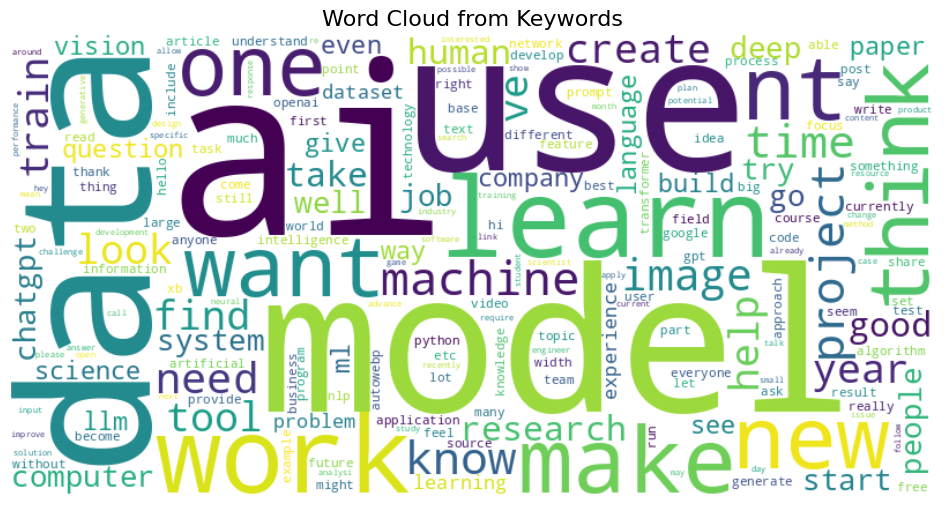

In [ ]:
# 키워드 열에서 모든 단어를 하나의 문자열로 결합
all_keywords = " ".join([" ".join(keywords) for keywords in df['keyword']])

# 워드클라우드 생성
wordcloud = WordCloud(
    width=800,
    height=400,
    background_color='white',
    colormap='viridis',
    collocations=False
).generate(all_keywords)

# 워드클라우드 시각화
plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("Word Cloud from Keywords", fontsize=16)
plt.show()